In [62]:
#!pip install praw transformers torch
import praw
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timedelta
from langdetect import detect, LangDetectException


In [63]:
user_agent = "Brand sentiment analysis"
reddit = praw.Reddit(
  client_id="ujQpmAa-rxhI6tgE246E4w",
  client_secret="BnhybdI_fallhH64Us6vutIfsXP21Q",
  user_agent=user_agent
)

### fetch reddit title and body

In [42]:
# def fetch_reddit_posts(subreddit, query, limit=100):
#     subreddit = reddit.subreddit(subreddit)
#     posts = []
#     for post in subreddit.search(query, limit=limit):
#         if post.selftext and len(post.selftext.split()) > 6 and len(post.selftext.split()) <= 512:  # This checks if the body (selftext) is not empty
#           posts.append([post.created_utc, post.title, post.selftext])
#     df = pd.DataFrame(posts, columns=["Date", "Title", "Body"])
#     df['Date'] = pd.to_datetime(df['Date'], unit='s')
#     return df


### fetch reddit comments only 

In [69]:
def fetch_reddit_comments(subreddit, query, limit=100, months=6):
    subreddit = reddit.subreddit(subreddit)
    posts = []
    for post in subreddit.search(query, limit=limit):
        post_date = datetime.utcfromtimestamp(post.created_utc)
        post.comments.replace_more(limit=0)  # Ensure all comments are fetched
        comments = post.comments.list()
        #print(comments)
        if comments:
            for comment in comments:
                if hasattr(comment, 'body') and comment.body.strip():  # Ensure comment body is not empty or just whitespace
                    try:
                        comment_date = datetime.utcfromtimestamp(comment.created_utc)
                        if detect(comment.body) == 'en' and comment_date >= datetime.now() - timedelta(days=months*30):  # Adjust to the specific time frame
                            posts.append([comment_date, post.title, comment.body, post.url])
                            english = True
                    except LangDetectException:  # Handle cases where language detection fails
                        continue

    df = pd.DataFrame(posts, columns=["Date", "Title", "Comment", "Url"])
    df['Date'] = pd.to_datetime(df['Date'], unit='s')
    df['Source'] = 'Reddit'
    if english == True: 
        df['Language'] = 'English'
    return df

In [70]:
# df_chatgpt = fetch_reddit_posts('all', 'ChatGPT', 100)
# df_gemini = fetch_reddit_posts('all', 'Gemini AI', 100)
# df_copilot = fetch_reddit_posts('all', 'Copilot AI', 100)

df_neutrogena = fetch_reddit_comments('all', 'neutrogena', 100)
# df_gemini = fetch_reddit_comments('all', 'Gemini AI', 100)
# df_copilot = fetch_reddit_comments('all', 'Copilot AI', 100)

In [52]:
# def clean_text(text):
#   #text = re.sub(r'[^\x00-\x7F]+', ' ', text)
#   text = re.sub(r'\s+', ' ', text) #Remove Extra Whitespace
#   text = re.sub(r'http\S+', '', text)
#   text = re.sub(r'[^\w\s]', '', text)
#   return text.lower()

# df_neutrogena['Comment'] = df_neutrogena['Comment'].apply(clean_text)
# df_chatgpt['Body'] = df_chatgpt['Body'].apply(clean_text)
# df_gemini['Body'] = df_gemini['Body'].apply(clean_text)
# df_copilot['Body'] = df_copilot['Body'].apply(clean_text)
# df_chatgpt['Title'] = df_chatgpt['Title'].apply(clean_text)
# df_gemini['Title'] = df_gemini['Title'].apply(clean_text)
# df_copilot['Title'] = df_copilot['Title'].apply(clean_text)

In [71]:
df_neutrogena

,Date,Title,Comment,Url,Source,Language
0,2024-01-19 18:50:34,[Misc] Your thoughts on Neutrogena?,"In my skincare routine, I'm unsure whether I ...",https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English
1,2024-01-21 02:30:22,[Misc] Your thoughts on Neutrogena?,Neutrogena now marketing wrinkle cream to chil...,https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English
2,2024-01-31 06:11:00,[Misc] Your thoughts on Neutrogena?,The orange oil free acne cleanser WOULDVE been...,https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English
3,2024-01-12 13:05:43,What are your thoughts on Neutrogena sunscreen ?,Is it necessary to double cleans for this suns...,https://i.redd.it/ultpbnpxf1ya1.jpg,Reddit,English
4,2024-04-06 03:25:24,What are your thoughts on Neutrogena sunscreen ?,How often do you reapply it??,https://i.redd.it/ultpbnpxf1ya1.jpg,Reddit,English
...,...,...,...,...,...,...
965,2024-05-19 23:50:22,FREE Neutrogena Beach Defense Sunscreen Lotion...,If not shipping may work. I want to see if I c...,https://www.reddit.com/gallery/1cw1ic0,Reddit,English
966,2024-05-20 02:41:40,FREE Neutrogena Beach Defense Sunscreen Lotion...,"I got the Nivea tins last week, too! 😊",https://www.reddit.com/gallery/1cw1ic0,Reddit,English
967,2024-05-19 23:53:23,FREE Neutrogena Beach Defense Sunscreen Lotion...,If pick up you need to add something else with...,https://www.reddit.com/gallery/1cw1ic0,Reddit,English
968,2024-05-19 23:50:44,FREE Neutrogena Beach Defense Sunscreen Lotion...,Would you mind reporting back?,https://www.reddit.com/gallery/1cw1ic0,Reddit,English


In [73]:
# Load sentiment analysis pipeline
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

def truncate_text(text, max_tokens=510):
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    return tokenizer.convert_tokens_to_string(tokens)

def get_sentiment_score(text):
    truncated_text = truncate_text(text)
    result = sentiment_pipeline(truncated_text)[0]
    return result['label'], result['score']

# # Apply sentiment analysis to both Title and Body
# def apply_sentiment_analysis(df):
#     df['Title_Sentiment'], df['Title_Sentiment_Score'] = zip(*df['Title'].apply(get_sentiment_score))
#     df['Body_Sentiment'], df['Body_Sentiment_Score'] = zip(*df['Body'].apply(get_sentiment_score))
#     return df

# Apply sentiment analysis
df_neutrogena['Sentiment'], df_neutrogena['Sentiment_Score'] = zip(*df_neutrogena['Comment'].apply(get_sentiment_score))
# df_chatgpt['Sentiment'], df_chatgpt['Sentiment_Score'] = zip(*df_chatgpt['Body'].apply(get_sentiment_score))
# df_gemini['Sentiment'], df_gemini['Sentiment_Score'] = zip(*df_gemini['Body'].apply(get_sentiment_score))
# df_copilot['Sentiment'], df_copilot['Sentiment_Score'] = zip(*df_copilot['Body'].apply(get_sentiment_score))

Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through the model will result in indexing errors


In [74]:
df_neutrogena
df_neutrogena.to_csv('neutrogena', sep=',', index=False, encoding='utf-8')

In [67]:
# # Combine title and body and apply sentiment analysis
# def apply_combined_sentiment_analysis(df):
#     df['Combined_Text'] = df['Title'] + " " + df['Body']
#     df['Combined_Sentiment'], df['Combined_Sentiment_Score'] = zip(*df['Combined_Text'].apply(get_sentiment_score))
#     return df

# # Example DataFrames
# # Assuming df_chatgpt, df_gemini, df_copilot are already defined and have 'Title' and 'Body' columns
# df_chatgpt = apply_combined_sentiment_analysis(df_chatgpt)
# df_gemini = apply_combined_sentiment_analysis(df_gemini)
# df_copilot = apply_combined_sentiment_analysis(df_copilot)

In [75]:
# Display sentiment statistics
print("ChatGPT Sentiment Statistics:")
print(df_neutrogena['Sentiment'].value_counts(normalize=True))

# print("Gemini AI Sentiment Statistics:")
# print(df_gemini['Sentiment'].value_counts(normalize=True))

# print("Copilot AI Sentiment Statistics:")
# print(df_copilot['Sentiment'].value_counts(normalize=True))


ChatGPT Sentiment Statistics:
Sentiment
NEGATIVE    0.66701
POSITIVE    0.33299
Name: proportion, dtype: float64


In [76]:
df_neutrogena

,Date,Title,Comment,Url,Source,Language,Sentiment,Sentiment_Score
0,2024-01-19 18:50:34,[Misc] Your thoughts on Neutrogena?,"In my skincare routine, I'm unsure whether I ...",https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English,NEGATIVE,0.998135
1,2024-01-21 02:30:22,[Misc] Your thoughts on Neutrogena?,Neutrogena now marketing wrinkle cream to chil...,https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English,NEGATIVE,0.996420
2,2024-01-31 06:11:00,[Misc] Your thoughts on Neutrogena?,The orange oil free acne cleanser WOULDVE been...,https://www.reddit.com/r/SkincareAddiction/com...,Reddit,English,NEGATIVE,0.990605
3,2024-01-12 13:05:43,What are your thoughts on Neutrogena sunscreen ?,Is it necessary to double cleans for this suns...,https://i.redd.it/ultpbnpxf1ya1.jpg,Reddit,English,NEGATIVE,0.999275
4,2024-04-06 03:25:24,What are your thoughts on Neutrogena sunscreen ?,How often do you reapply it??,https://i.redd.it/ultpbnpxf1ya1.jpg,Reddit,English,NEGATIVE,0.980498
...,...,...,...,...,...,...,...,...
965,2024-05-19 23:50:22,FREE Neutrogena Beach Defense Sunscreen Lotion...,If not shipping may work. I want to see if I c...,https://www.reddit.com/gallery/1cw1ic0,Reddit,English,POSITIVE,0.991728
966,2024-05-20 02:41:40,FREE Neutrogena Beach Defense Sunscreen Lotion...,"I got the Nivea tins last week, too! 😊",https://www.reddit.com/gallery/1cw1ic0,Reddit,English,NEGATIVE,0.988818
967,2024-05-19 23:53:23,FREE Neutrogena Beach Defense Sunscreen Lotion...,If pick up you need to add something else with...,https://www.reddit.com/gallery/1cw1ic0,Reddit,English,NEGATIVE,0.999157
968,2024-05-19 23:50:44,FREE Neutrogena Beach Defense Sunscreen Lotion...,Would you mind reporting back?,https://www.reddit.com/gallery/1cw1ic0,Reddit,English,NEGATIVE,0.992863


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


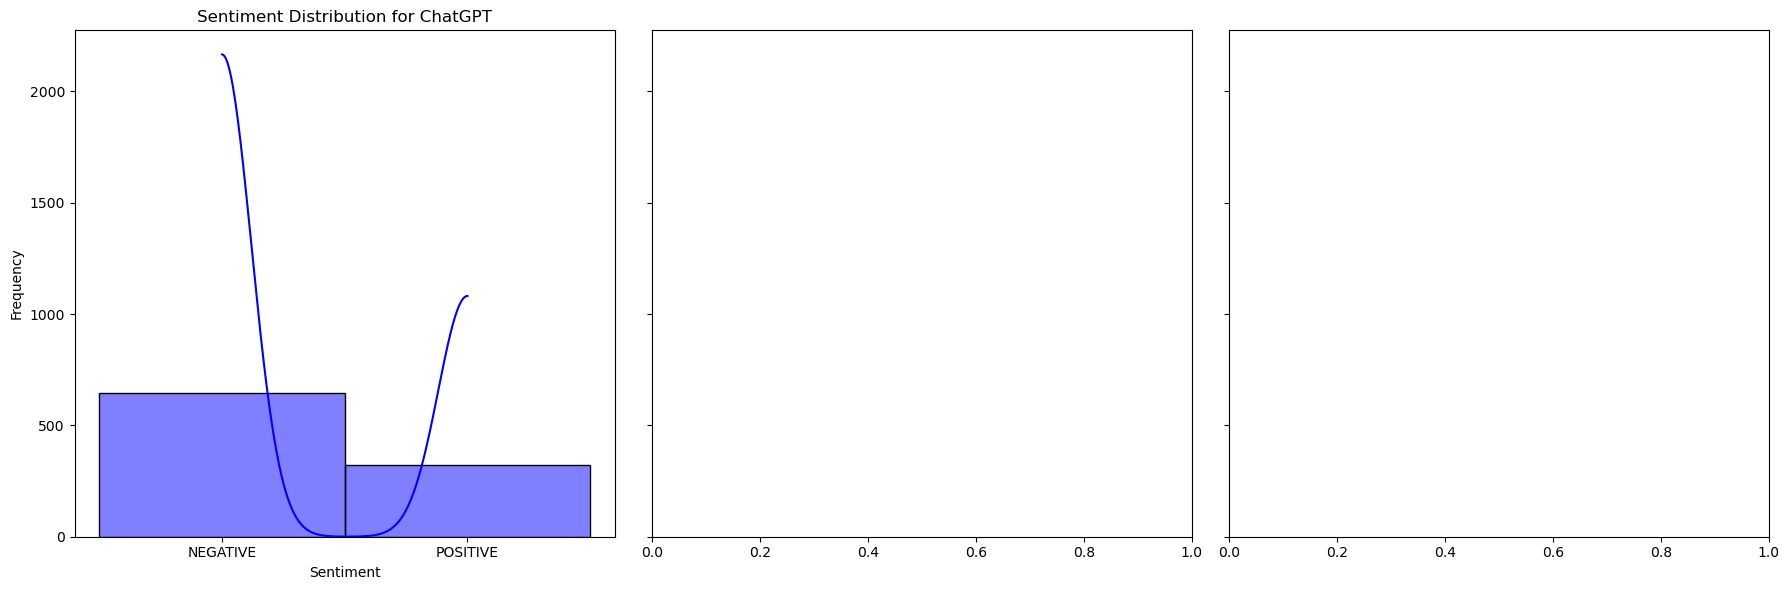

In [77]:
# Plot sentiment distribution for ChatGPT
# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot sentiment distribution for ChatGPT
sns.histplot(df_neutrogena['Sentiment'], kde=True, color='blue', ax=axes[0])
axes[0].set_title('Sentiment Distribution for ChatGPT')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Frequency')

# # Plot sentiment distribution for Gemini
# sns.histplot(df_gemini['Sentiment'], kde=True, color='red', ax=axes[1])
# axes[1].set_title('Sentiment Distribution for Gemini')
# axes[1].set_xlabel('Sentiment')
# axes[1].set_ylabel('Frequency')

# # Plot sentiment distribution for Copilot
# sns.histplot(df_copilot['Sentiment'], kde=True, color='green', ax=axes[2])
# axes[2].set_title('Sentiment Distribution for Copilot')
# axes[2].set_xlabel('Sentiment')
# axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

# other hugging face model

In [59]:
# Load sentiment analysis pipeline
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

def truncate_text(text, max_tokens=512):
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    return tokenizer.convert_tokens_to_string(tokens)

def get_sentiment_score(text):
    truncated_text = truncate_text(text)
    result = sentiment_pipeline(truncated_text)[0]
    return result['label'], result['score']

# Apply sentiment analysis
df_chatgpt['Sentiment'], df_chatgpt['Sentiment_Score'] = zip(*df_chatgpt['Body'].apply(get_sentiment_score))
df_gemini['Sentiment'], df_gemini['Sentiment_Score'] = zip(*df_gemini['Body'].apply(get_sentiment_score))
df_copilot['Sentiment'], df_copilot['Sentiment_Score'] = zip(*df_copilot['Body'].apply(get_sentiment_score))

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [60]:
# Display sentiment statistics
print("ChatGPT Sentiment Statistics:")
print(df_chatgpt['Sentiment'].value_counts(normalize=True))

print("Gemini AI Sentiment Statistics:")
print(df_gemini['Sentiment'].value_counts(normalize=True))

print("Copilot AI Sentiment Statistics:")
print(df_copilot['Sentiment'].value_counts(normalize=True))

ChatGPT Sentiment Statistics:
Sentiment
surprise    0.368421
neutral     0.263158
anger       0.157895
sadness     0.105263
joy         0.105263
Name: proportion, dtype: float64
Gemini AI Sentiment Statistics:
Sentiment
neutral     0.413793
surprise    0.275862
fear        0.137931
joy         0.103448
anger       0.068966
Name: proportion, dtype: float64
Copilot AI Sentiment Statistics:
Sentiment
neutral     0.379310
anger       0.172414
surprise    0.172414
fear        0.137931
joy         0.103448
sadness     0.034483
Name: proportion, dtype: float64


In [62]:
df_chatgpt

,Date,Title,Body,Sentiment,Sentiment_Score
0,2023-04-30 11:06:08,what do you all actually use chatgpt for,chatgpt is cool and has many every now and the...,neutral,0.471515
1,2023-05-23 16:13:52,chatgpt is the devil,four students so far have used chatgpt to writ...,sadness,0.925634
2,2024-04-05 17:57:45,kids think chatgpt is going to save them turni...,love what just happened my students turned in ...,anger,0.721369
3,2024-03-07 21:55:30,chatgpt is a doubleedged sword,tldr tell chatgpt to explain the solution rath...,joy,0.955831
4,2023-04-09 11:07:32,chatgpt assistant chatgpt keyboard for ios use...,last week we shared omni ai while the idea see...,neutral,0.700895
5,2024-03-13 23:02:01,obvious chatgpt prompt reply in published paper,look it up crazy how it good through peer review,surprise,0.772126
6,2024-02-01 17:14:57,chatgpt saved me 250,tldr chatgpt helped me jump start my hybrid to...,neutral,0.471386
7,2023-11-24 15:15:56,chatgpt has become unusably lazy,i asked chatgpt to fill out a csv file of 15 e...,anger,0.386609
8,2023-11-07 15:14:51,top 20 rappers by chatgpt,the question i asked was who are the top 20 be...,surprise,0.500421
9,2023-04-26 17:46:33,video call with chatgpt,hi everyone weve built a realtime video friend...,neutral,0.694812


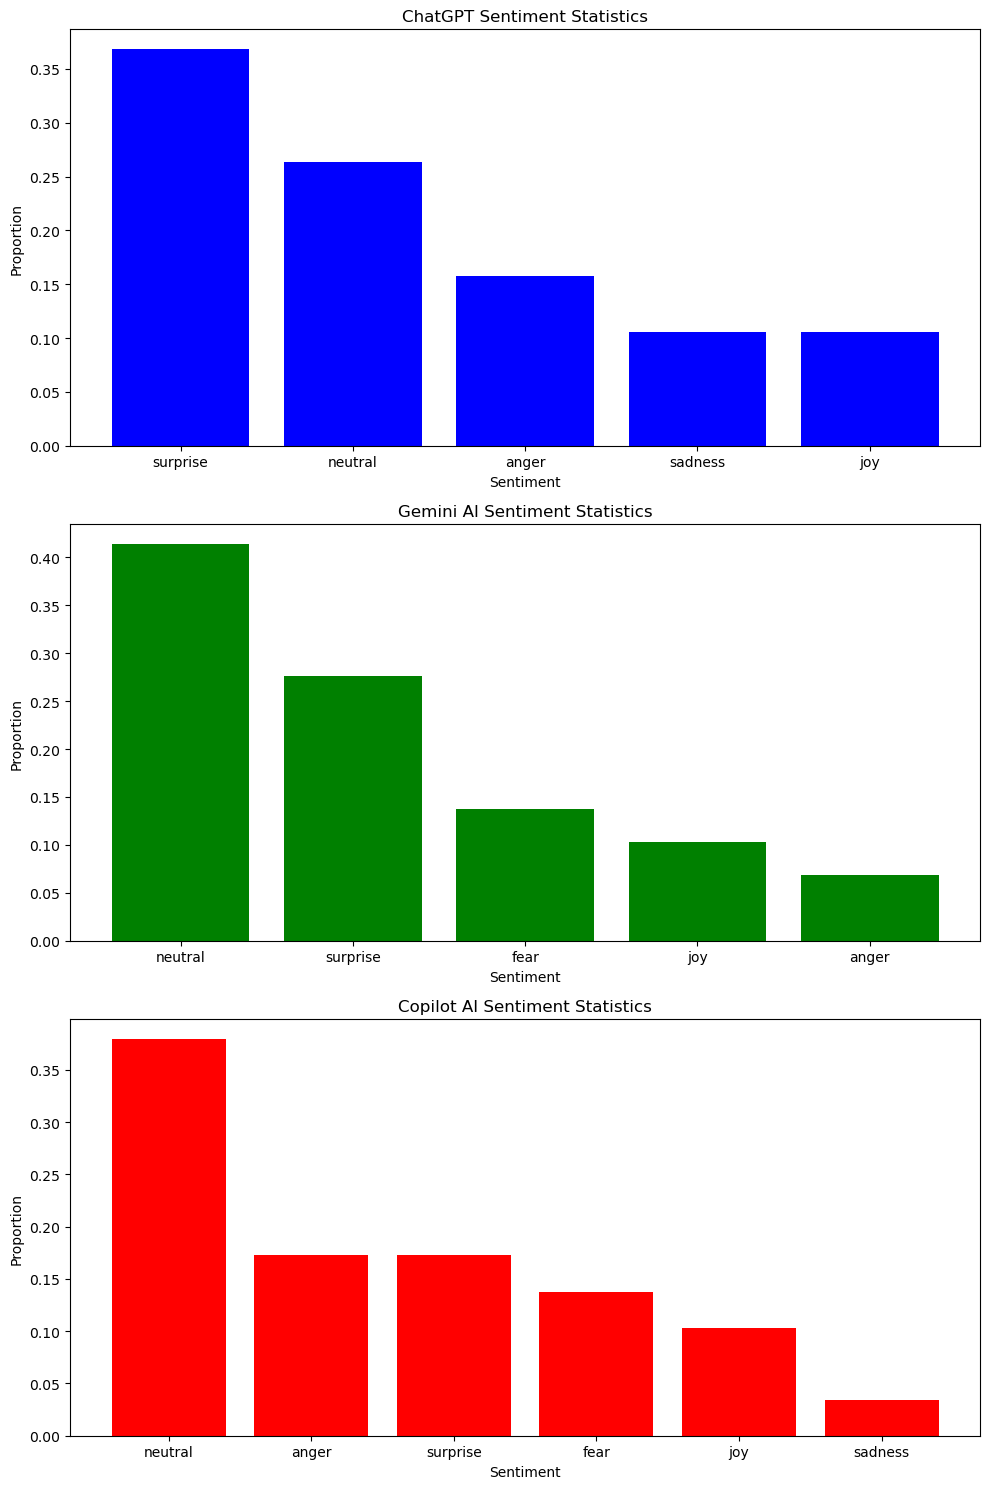

In [61]:

# Prepare the data
chatgpt_sentiment = df_chatgpt['Sentiment'].value_counts(normalize=True)
gemini_sentiment = df_gemini['Sentiment'].value_counts(normalize=True)
copilot_sentiment = df_copilot['Sentiment'].value_counts(normalize=True)

# Plot the sentiment statistics
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot for ChatGPT
axes[0].bar(chatgpt_sentiment.index, chatgpt_sentiment.values, color='blue')
axes[0].set_title('ChatGPT Sentiment Statistics')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Proportion')

# Plot for Gemini
axes[1].bar(gemini_sentiment.index, gemini_sentiment.values, color='green')
axes[1].set_title('Gemini AI Sentiment Statistics')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Proportion')

# Plot for Copilot
axes[2].bar(copilot_sentiment.index, copilot_sentiment.values, color='red')
axes[2].set_title('Copilot AI Sentiment Statistics')
axes[2].set_xlabel('Sentiment')
axes[2].set_ylabel('Proportion')

plt.tight_layout()
plt.show()
